In [38]:
import numpy as np
import cv2

def region_of_interest(img, vertices):
    mask = np.zeros_like(img) # define a blank mask that matches the image height / width.
    match_mask_color = 255 
    cv2.fillPoly(mask, vertices, match_mask_color) # fill inside the polygon
    masked_image = cv2.bitwise_and(img, mask) # return the image only where mask pixels match
    return masked_image

In [86]:
def draw_lines(img, lines, color = [255, 0, 0], thickness = 3):
    if lines is None:
        return
    
    img = np.copy(img) # make a copy of the original image
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype = np.uint8,) # create a blank image that matches the original
    
    for line in lines: # loop over all lines and draw them on the blank image
        for x1, y1, x2, y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
            
    img = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0) # merge the image with the lines onto the original(img * 0.8 + line_img * 1)
    return img   

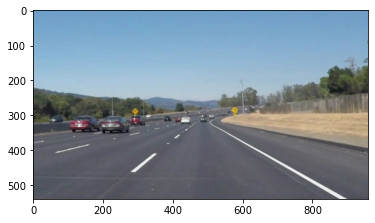

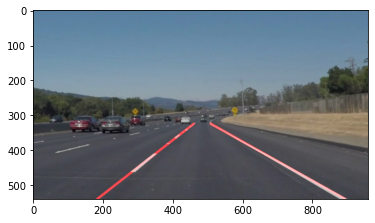

In [87]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

region_of_interest_vertices = [
    (0, height),
    (width / 2, height / 2),
    (width, height),
]

image = mpimg.imread('solidWhiteCurve.jpg')

plt.figure()
plt.imshow(image)
plt.show()

gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
cannyed_image = cv2.Canny(gray_image, 100, 200)

cropped_image = region_of_interest(
    cannyed_image,
    np.array([region_of_interest_vertices], np.int32),
)

lines = cv2.HoughLinesP(
    cropped_image,
    rho = 6,
    theta = np.pi / 60,
    threshold = 160,
    lines = np.array([]),
    minLineLength = 40,
    maxLineGap = 25
)

left_line_x = []
left_line_y = []
right_line_x = []
right_line_y = []

for line in lines:
    for x1, y1, x2, y2 in line:
        slope = (y2 - y1) / (x2 - x1)
        if math.fabs(slope) < 0.5: # 기울기의 절대값 비교
            continue
        if slope <= 0:# negative, left group
            left_line_x.extend([x1, x2])
            left_line_y.extend([y1, y2])
        else: # positive, right group
            right_line_x.extend([x1, x2])
            right_line_y.extend([y1, y2])
            
min_y = int(image.shape[0] * (3 / 5))
max_y = image.shape[0]            

poly_left = np.poly1d(np.polyfit(left_line_y, left_line_x, deg = 1)) # 1차원 직선 선형 모델 생성
left_x_start = int(poly_left(max_y)) # x 시작점 추정
left_x_end = int(poly_left(min_y)) # x 끝점 추정

poly_right = np.poly1d(np.polyfit(right_line_y, right_line_x, deg = 1))
right_x_start = int(poly_right(max_y))
right_x_end = int(poly_right(min_y))

line_image = draw_lines(
    image, [[[left_x_start, max_y, left_x_end, min_y], [right_x_start, max_y, right_x_end, min_y]]], thickness = 5)

plt.figure()
plt.imshow(line_image)
plt.show()